Upload kaggle.json and run below commands.

In [1]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [2]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
zip_ref = zipfile.ZipFile('gtsrb-german-traffic-sign.zip', 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [4]:
len(os.listdir('/content/data/test/'))

12631

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [6]:
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score
from keras.layers.normalization import BatchNormalization

In [7]:
tf.__version__

'2.5.0'

## Loading Images

In [8]:
train_path = '/content/data/train'

img_data = []
img_label = []
classes = 43

for i in range(classes):
    img_path = os.path.join(train_path, str(i))             # append 0 to 42 to path
    for img in os.listdir(img_path):                  # for every image in the path
        im = Image.open(img_path + '/' + img)         # open image
        im = im.resize((30,30))                       # resize it
        im = np.array(im)                             # convert to array
        img_data.append(im)
        img_label.append(i)

img_data = np.array(img_data)
img_label = np.array(img_label)

print('Image loading done..')

Image loading done..


In [9]:
img_data.shape

(39209, 30, 30, 3)

In [10]:
img_label.shape

(39209,)

In [11]:
img_label

array([ 0,  0,  0, ..., 42, 42, 42])

In [12]:
(unique, counts) = np.unique(img_label, return_counts=True)
(unique, counts)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 array([ 210, 2220, 2250, 1410, 1980, 1860,  420, 1440, 1410, 1470, 2010,
        1320, 2100, 2160,  780,  630,  420, 1110, 1200,  210,  360,  330,
         390,  510,  270, 1500,  600,  240,  540,  270,  450,  780,  240,
         689,  420, 1200,  390,  210, 2070,  300,  360,  240,  240]))

Checking out sample image..


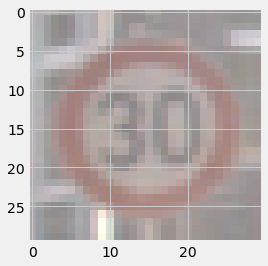

In [13]:
print('Checking out sample image..')

path = "/content/data/train/1/00001_00000_00000.png"
img = Image.open(path)
img = img.resize((30, 30))
plt.imshow(img)
plt.show()

In [14]:
print('Checking image in array form..')

sr = np.array(img)
sr

Checking image in array form..


array([[[182, 179, 182],
        [183, 177, 179],
        [185, 179, 179],
        ...,
        [149, 148, 150],
        [151, 150, 151],
        [156, 153, 154]],

       [[185, 181, 184],
        [175, 174, 176],
        [158, 159, 157],
        ...,
        [150, 148, 147],
        [150, 149, 148],
        [151, 149, 149]],

       [[182, 180, 182],
        [174, 176, 177],
        [154, 157, 156],
        ...,
        [163, 157, 158],
        [161, 160, 161],
        [159, 158, 158]],

       ...,

       [[166, 165, 169],
        [152, 157, 159],
        [150, 149, 146],
        ...,
        [149, 144, 142],
        [151, 144, 145],
        [152, 144, 146]],

       [[169, 167, 171],
        [154, 157, 158],
        [146, 148, 147],
        ...,
        [152, 146, 147],
        [150, 142, 142],
        [153, 143, 145]],

       [[167, 168, 171],
        [148, 156, 159],
        [141, 144, 145],
        ...,
        [148, 145, 147],
        [147, 141, 141],
        [153, 141, 142]]

In [15]:
sr.shape          # shape of each image

(30, 30, 3)

## Splitting dataset

In [16]:
X_train, X_test, y_train, y_test = train_test_split(img_data, img_label, test_size=0.2, random_state=20)

print("Training shape: ", X_train.shape, y_train.shape)
print("Testing shape: ", X_test.shape, y_test.shape)

Training shape:  (31367, 30, 30, 3) (31367,)
Testing shape:  (7842, 30, 30, 3) (7842,)


In [17]:
y_train[1]

2

In [18]:
y_train_cat = to_categorical(y_train, 43)
y_test_cat = to_categorical(y_test, 43)

In [19]:
y_train_cat[1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## CNN Model Building

Conv2D - 2D Convolution Layer

MaxPool2D – Maximum pooling layer is used to reduce the size of images

Dropout – Dropout is a regularization technique to reduce overfitting

Flatten – converts the data into a 1D array 

Dense –  for feed-forward neural network

In [20]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1, 1), activation='relu', padding = 'same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer = 'he_uniform'))
model.add(Dropout(rate=0.5))
model.add(Dense(classes, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [22]:
# training the model 
# using categorical_crossentropy as multiclass, if binary then use binary_crossentropy

model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])

In [23]:
epochs = 12
batch_size = 64

history = model.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_cat))

Epoch 1/12
491/491 [==============================] - 23s 12ms/step - loss: 2.3128 - accuracy: 0.4520 - val_loss: 0.1620 - val_accuracy: 0.9503
Epoch 2/12
491/491 [==============================] - 5s 10ms/step - loss: 0.2592 - accuracy: 0.9167 - val_loss: 0.0425 - val_accuracy: 0.9864
Epoch 3/12
491/491 [==============================] - 5s 10ms/step - loss: 0.0952 - accuracy: 0.9705 - val_loss: 0.0474 - val_accuracy: 0.9858
Epoch 4/12
491/491 [==============================] - 5s 10ms/step - loss: 0.0694 - accuracy: 0.9777 - val_loss: 0.0344 - val_accuracy: 0.9897
Epoch 5/12
491/491 [==============================] - 5s 10ms/step - loss: 0.1036 - accuracy: 0.9696 - val_loss: 0.0260 - val_accuracy: 0.9920
Epoch 6/12
491/491 [==============================] - 5s 10ms/step - loss: 0.0503 - accuracy: 0.9847 - val_loss: 0.0188 - val_accuracy: 0.9952
Epoch 7/12
491/491 [==============================] - 5s 10ms/step - loss: 0.0453 - accuracy: 0.9868 - val_loss: 0.0236 - val_accuracy: 0.994

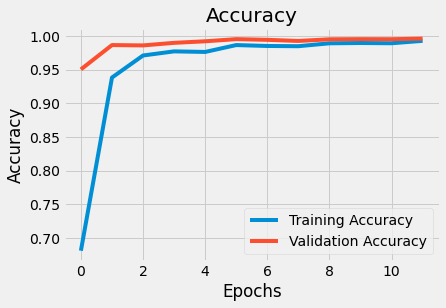

In [24]:
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

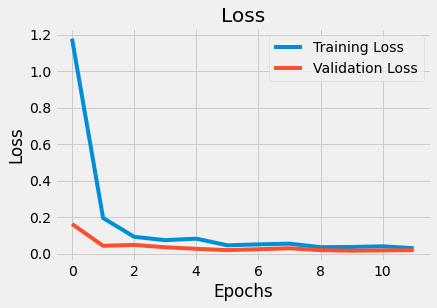

In [25]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Checking on Test Data

**First way of prediction using predict_classes.**

In [26]:
test = pd.read_csv('/content/data/Test.csv')

test_set_label = test['ClassId'].values

test_path = '/content/data'
test_imgs = test['Path'].values

test_data = []

for img in test_imgs:
    im = Image.open(test_path + '/' + img)
    im = im.resize((30,30))
    im = np.array(im)
    test_data.append(im)

test_data_new = np.array(test_data)
test_set_pred = model.predict_classes(test_data_new)

print('Accuracy: ', round(accuracy_score(test_set_label, test_set_pred)*100, 2))

Accuracy:  97.11


In [27]:
test_data_new.shape, test_set_pred.shape, test_set_label.shape

((12630, 30, 30, 3), (12630,), (12630,))

In [28]:
test_set_label[0:15]

array([16,  1, 38, 33, 11, 38, 18, 12, 25, 35, 12,  7, 23,  7,  4])

In [29]:
test_set_pred[0:15]

array([16,  1, 38, 33, 11, 38, 18, 12, 25, 35, 12,  7, 23,  7,  4])

**Second way of prediction using predict and then argmax.**

In [30]:
test = pd.read_csv('/content/data/Test.csv')

test_set_label = test['ClassId'].values

test_path = '/content/data'
test_imgs = test['Path'].values

test_data = []

for img in test_imgs:
    im = Image.open(test_path + '/' + img)
    im = im.resize((30,30))
    im = np.array(im)
    test_data.append(im)

test_data_new = np.array(test_data)
test_set_pred = model.predict(test_data_new)

In [31]:
test_set_pred[0]             # probability values of 43 classes of 1st image

array([8.04347115e-32, 9.76670780e-24, 1.83097466e-27, 8.19742522e-24,
       9.58353802e-32, 6.68760346e-18, 5.25533219e-25, 3.26859657e-22,
       4.85030434e-28, 1.10754534e-15, 2.38113812e-26, 1.01436666e-20,
       2.28361707e-21, 1.48212587e-32, 3.08216801e-30, 1.51213937e-21,
       1.00000000e+00, 7.87571591e-33, 4.19167282e-26, 7.18466409e-26,
       1.05132910e-25, 3.46552258e-36, 6.36401334e-36, 7.06246461e-26,
       1.77405183e-28, 1.64247429e-31, 1.01538457e-28, 4.34989980e-32,
       4.21598625e-25, 9.16882765e-29, 5.97369687e-28, 1.19651484e-37,
       2.17584192e-31, 1.19552888e-23, 1.40274366e-27, 4.55906637e-20,
       2.90054491e-24, 1.24453339e-24, 2.10174845e-33, 4.90906753e-29,
       6.58232109e-16, 7.96937815e-24, 5.98553836e-27], dtype=float32)

In [32]:
test_set_pred = np.argmax(test_set_pred, axis=1)

In [33]:
test_set_pred[0]

16

In [34]:
print('Accuracy: ', round(accuracy_score(test_set_label, test_set_pred)*100, 2))

Accuracy:  97.11


### Checking a Test Case

In [35]:
test = pd.read_csv('/content/data/Test.csv')
test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


Testing out sample image..


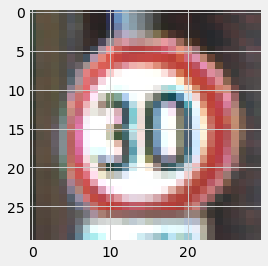

In [36]:
print('Testing out sample image..')

path = "/content/data/test/00001.png"
img = Image.open(path)
img = img.resize((30, 30))
plt.imshow(img)
plt.show()

In [37]:
img_array = np.array(img)
img_array = img_array.reshape(-1,30,30,3)
pred = model.predict_classes(img_array)

In [38]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [39]:
given_class = test.iloc[1]['ClassId']     # taking the 2nd row's class
pred_class = pred[0]                      # taking the predicted value

print('Given signal is: ', classes[given_class])
print('Predicted signal is: ', classes[pred_class])
print()

if(given_class == pred_class):
    print('Model predicted correctly!')
else:
    print('Bad job by Model!')

Given signal is:  Speed limit (30km/h)
Predicted signal is:  Speed limit (30km/h)

Model predicted correctly!


**Saving the model..**

In [40]:
model.save('traffic_model.h5')

## CNN + Random Forest

In [41]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1, 1), activation='relu', padding = 'same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))

model.add(Flatten())

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        2432      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        25632     
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 64)       

In [43]:
x = model.output 
x.shape

TensorShape([None, 3136])

In [44]:
x = Dense(128, activation = 'relu', kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(43, activation = 'softmax')(x)

In [45]:
# Make a new model combining both feature extractor and x

cnn_model = Model(inputs=model.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [46]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4_input (InputLayer)  [(None, 30, 30, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        2432      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        25632     
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0     

In [47]:
epochs = 12
batch_size = 64

history = cnn_model.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_cat))

Epoch 1/12
491/491 [==============================] - 7s 11ms/step - loss: 1.7438 - accuracy: 0.5588 - val_loss: 0.1780 - val_accuracy: 0.9384
Epoch 2/12
491/491 [==============================] - 5s 10ms/step - loss: 0.0999 - accuracy: 0.9698 - val_loss: 0.0519 - val_accuracy: 0.9860
Epoch 3/12
491/491 [==============================] - 5s 10ms/step - loss: 0.0437 - accuracy: 0.9859 - val_loss: 0.0735 - val_accuracy: 0.9762
Epoch 4/12
491/491 [==============================] - 5s 10ms/step - loss: 0.0290 - accuracy: 0.9911 - val_loss: 0.0432 - val_accuracy: 0.9881
Epoch 5/12
491/491 [==============================] - 5s 10ms/step - loss: 0.0313 - accuracy: 0.9895 - val_loss: 0.0357 - val_accuracy: 0.9907
Epoch 6/12
491/491 [==============================] - 5s 10ms/step - loss: 0.0228 - accuracy: 0.9928 - val_loss: 0.0341 - val_accuracy: 0.9918
Epoch 7/12
491/491 [==============================] - 5s 10ms/step - loss: 0.0209 - accuracy: 0.9940 - val_loss: 0.0611 - val_accuracy: 0.9839

In [48]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31367, 30, 30, 3), (31367,), (7842, 30, 30, 3), (7842,))

In [49]:
y_train_cat.shape, y_test_cat.shape

((31367, 43), (7842, 43))

In [50]:
test_data_new.shape, test_set_label.shape

((12630, 30, 30, 3), (12630,))

In [51]:
# using features from CNN for RF

X_for_RF = model.predict(X_train)

In [52]:
X_for_RF.shape

(31367, 3136)

In [53]:
X_for_RF[0]

array([-0.05691013, -0.14312626, -0.52214324, ..., -0.47306585,
       -0.11080763, -0.18388867], dtype=float32)

In [54]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 20)

In [55]:
# train the model on training data

RF_model.fit(X_for_RF, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [56]:
X_train[0]

array([[[ 84, 109,  73],
        [ 61,  78,  48],
        [ 58,  73,  47],
        ...,
        [169, 147,  88],
        [134, 115,  65],
        [151, 119,  80]],

       [[ 73,  76,  54],
        [ 73,  67,  49],
        [ 75,  68,  46],
        ...,
        [122, 108,  57],
        [117,  98,  60],
        [137, 114,  79]],

       [[ 94,  86,  60],
        [ 80,  73,  53],
        [ 76,  68,  49],
        ...,
        [136, 123,  60],
        [130, 111,  48],
        [119, 102,  48]],

       ...,

       [[253, 255, 223],
        [236, 255, 221],
        [227, 255, 206],
        ...,
        [ 85, 110,  72],
        [118, 129,  98],
        [214, 206, 171]],

       [[254, 255, 220],
        [234, 255, 222],
        [225, 255, 207],
        ...,
        [ 74, 107,  73],
        [ 79, 104,  76],
        [195, 203, 165]],

       [[236, 255, 204],
        [225, 254, 206],
        [223, 255, 203],
        ...,
        [ 68, 101,  79],
        [ 73,  93,  74],
        [133, 135,  90]]

In [57]:
y_train[0]

17

In [58]:
X_for_RF[0]

array([-0.05691013, -0.14312626, -0.52214324, ..., -0.47306585,
       -0.11080763, -0.18388867], dtype=float32)

In [59]:
test_data_new[0]

array([[[116, 140, 175],
        [116, 138, 171],
        [119, 138, 173],
        ...,
        [102, 119, 150],
        [101, 122, 149],
        [ 93, 112, 139]],

       [[116, 142, 177],
        [116, 141, 175],
        [117, 141, 174],
        ...,
        [120, 143, 178],
        [122, 144, 176],
        [122, 142, 174]],

       [[118, 142, 174],
        [116, 141, 175],
        [114, 140, 172],
        ...,
        [121, 144, 181],
        [122, 144, 180],
        [119, 142, 178]],

       ...,

       [[117, 137, 168],
        [115, 135, 165],
        [116, 135, 164],
        ...,
        [116, 138, 170],
        [116, 136, 168],
        [118, 139, 171]],

       [[116, 136, 166],
        [115, 134, 167],
        [115, 133, 165],
        ...,
        [114, 135, 168],
        [116, 136, 166],
        [115, 139, 167]],

       [[112, 135, 166],
        [111, 134, 165],
        [119, 135, 166],
        ...,
        [115, 137, 166],
        [117, 138, 167],
        [114, 140, 170]]

In [60]:
y_test[0]

13

In [61]:
# sending test data through CNN model
X_test_feature = model.predict(test_data_new)

# predicting using the trained RF model
prediction_RF = RF_model.predict(X_test_feature)

In [62]:
X_test_feature.shape, prediction_RF.shape

((12630, 3136), (12630,))

In [63]:
test_set_label

array([16,  1, 38, ...,  6,  7, 10])

In [64]:
prediction_RF

array([16,  1, 38, ...,  3,  7, 10])

In [65]:
print('Accuracy: ', round(accuracy_score(test_set_label, prediction_RF)*100, 2))

Accuracy:  95.64
